*Luis Antonio Ortega Andrés    
Antonio Coín Castro*
# Métodos Avanzados en Aprendizaje Automático

In [10]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

### Funciones auxiliares

In [5]:
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    print(z)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

In [6]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

In [7]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

## Gradient Boosting

$\DeclareMathOperator*{\argmin}{arg\,min}$

El algoritmo de Gradient Boosting persigue construir un clasificador *ensemble* mediante un modelo aditivo, es decir, como suma de clasificadores débiles (*weak classifiers*). La idea general es obtener un clasificador $F(x)$ de la forma

$$F(x)=\sum_{i=1}^M h_m(x),$$

de manera que realizamos una construcción iterativa en M pasos:

$$F_m(x)=F_{m-1}(x) + \gamma_mh_m(x), \quad m=1,\dots,M.$$

Los multiplicadores $\gamma_m$ son constantes que marcan el tamaño del paso y ponderan el peso de cada clasificador débil. El objetivo es optimizar los valores de $\gamma_m$ y $h_m$ para minimizar la pérdida entre las predicciones y los valores reales en el conjunto de entrenamiento, utilizando un esquema de gradiente descendente. De esta forma, definimos nuestro clasificador inicial como aquella constante que minimiza la función de pérdida.

Pasamos ahora a describir el algoritmo de Gradient Boosting:

**Entrada**: 

- Conjunto de entrenamiento $\{(x_n, y_n)\}_{n=1,\dots,N}$.
- Función de pérdida puntual diferenciable $L(y,F(x))$.
- Número de número de iteraciones $M$.

**Procedimiento**:

1. Se inicializa el modelo con un clasificador constante que minimice la pérdida esperada:
$$
F_0 (x) = \argmin_{\gamma \in \mathbb R} \sum_{n=1}^N L(y_n, \gamma).
$$
2. Para $m = 1,\dots,M$:
    1. Se calculan los *pseudo-residuos*:
    $$
        r_{nm} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} \quad n = 1,\dots,N.
    $$
    
    2. Se ajusta un modelo base $h_m(x)$ a los pseudo-residuos, es decir, se entrena $h_m$ sobre el conjunto $\{x_n, r_{nm}\}_{n=1,\dots,N}$.
    3. Se estima el multiplicador $\gamma_m$ que minimiza el error en entrenamiento, utilizando si es necesario un único paso del método de Newton-Raphson:
    $$
    \gamma_m = \argmin_\gamma \sum_{n=1}^N L(y_n, F_{m-1}(x_n) + \gamma h_m(x_n)).
    $$
    4. Se actualiza el modelo:
    $$
    F_m(x) =F_{m-1}(x) + \gamma_m h_m(x).
    $$
    
3. Devolvemos $F_M(x)$ como modelo final en el caso de regresión, o alguna transformación de la misma para clasificación, que transforme valores continuos en etiquetas de clase teniendo en cuenta cuál es la función de pérdida.

### Error cuadrático

Para el caso de regresión utilizamos como función de pérdida el error cuadrático entre predicciones y valores reales (convenientemente dividido entre 2 para simplificar los cálculos):

$$
L(y, F(x)) = \frac{1}{2}(y - F(x))^2.
$$

Veamos ahora con detalle cuáles son los elementos que modelan el algoritmo en este caso.

1. **Estimador inicial**. El valor que minimiza la pérdida cuadrática coincide con la media de las respuestas de los datos de entrenamiento:
$$
F_0(x) = \argmin_\gamma \sum_{n=1}^N L(y_n, \gamma) = \argmin_\gamma \sum_{n=1}^N (y_n - \gamma)^2
$$
$$
\dfrac{\partial \sum_{n=1}^N L(y_n, \gamma)}{\partial \gamma} = -\sum_{n=1}^N(y_n - \gamma) = 0 \implies F_0(x) = \frac{1}{N}\sum_{n=1}^N y_n = \bar{y}.
$$

2. **Pseudo-residuos**. Como la función de pérdida es derivable, podemos calcular explícitamente su derivada parcial respecto de la segunda variable:
$$
r_{nm} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = -\left[ \frac{\partial}{\partial F(x_n)}\frac{1}{2}(y_n - F(x_n)^2 \right]_{F(x) = F_{m-1}(x)} = y_n - F_{m-1}(x_n).$$

3. **Multiplicador**. Queremos minimizar en $\gamma$ la siguiente función:
$$
f_m(\gamma) = \sum_{n=1}^N \frac{1}{2}(y_n - F_{m-1}(x_n) - \gamma h_m(x_n))^2
$$
Para ello, pretendemos calcular su derivada e igualarla a $0$. En primer lugar, se tiene:
$$
f_m'(\gamma) = \sum_{n=1}^N -h_m(x_n)(y_n - F_{m-1}(x_n) - \gamma h_m(x_n)) 
$$
Ahora, como $h_m$ se ha entrenado para que
$$
h_m(x_n) \approx r_{nm} = y_n- F_{m-1}(x_n),
$$
podemos aproximar:
$$
f_m'(\gamma) = \sum_{n=1}^N - (y_n- F_{m-1}(x_n))(y_n- F_{m-1}(x_n) - \gamma (y_n- F_{m-1}(x_n))) = (\gamma - 1) \sum_{n=1}^N (y_n- F_{m-1}(x_n))^2.
$$
Por tanto, concluimos que:
$$
f_m'(\gamma)= 0 \implies \gamma_m^* = 1.$$

Teniendo todo esto en cuenta, creamos una clase que represente estos elementos para la pérdida cuadrática.

In [15]:
class SquaredErrorLoss:
    """ 
    Define elementos para la función de pérdida cuadrática.
    """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la pérdida con la salida 'y'. 
            Para la pérdida cuadrática este valor coincide con la media de los 
            valores de 'y'. """
        
        return np.mean(y)

    def residuos(_, y, F):
        """ Calcula los pseudo-residuos para un objetivo 'y' y 
            una salida del modelo 'F'. """

        return y - F

    def paso_newton(_, y, residuos, hm):
        """ Recibe el valor a predecir ('y'), los pseudo-residuos ('residuos') 
            sobre los que se entrena el nuevo regresor, y la salida 
            del mismo ('hm'). Calcula el multiplicador asociado al paso m. """
        
        return 1.0
    
    def __call__(self, y, F):
        """ Devuelve el valor puntual de la función de pérdida para un 
            objetivo 'y' y una salida del modelo F. """
        
        return (y - F) ** 2

### Error logístico

Hacemos el mismo análisis para el caso de clasificación, utilizando como función de pérdida el error logístico:

$$
L(y, F(x)) = \log(1 + e^{-2yF(x)}), \quad y \in \{-1,1\}.
$$

En este caso la estrategia será un poco distinta, pues aprovecharemos que los estimadores débiles que usamos son árboles de decisión de profundidad $J$, es decir, de la forma 

$$h_m(x)=\sum_{j=1}^{J} b_{jm}\mathcal{I}(x \in R_{jm}),$$

donde $\mathcal I(\cdot)$ es la función indicadora y $\{R_{jm}\}_{j=1,\dots,J}$ son las regiones en las que se divide el espacio de entrada, representadas por las hojas terminales del árbol en el paso $m$-ésimo. En este caso, podemos mejorar la calidad del ajuste calculando un multiplicador diferente en cada nodo, es decir, construyendo los estimadores como

$$F_m(x) = F_{m-1}(x) + \sum_{j=1}^{J} \gamma_{jm}\mathcal{I}(x \in R_{jm}).$$

Notamos que, esto es equivalente a "descartar" los valores $\{b_{jm}\}$ del árbol de decisión y considerar que los multiplicadores son $\gamma_{jm}=\rho_m b_{jm}$, donde $\rho_m$ serían los multiplicadores a nivel de árbol que usaríamos siguiendo el algoritmo general. Por último, teniendo en cuenta que las regiones $\{R_{jm}\}$ son disjuntas, concluimos que

$$\gamma_{jm}= \argmin_\gamma \sum_{x_n \in R_{jm}} L(y_n, F_{m-1}(x_n)+\gamma). $$

Veamos entonces cómo serían los pasos del algoritmo:

1. **Estimador inicial**. En este caso, <a href="#Análisis-matemático-de-la-pérdida-logarítmica">se puede demostrar</a> que el valor del estimador constante inicial es:
$$
F_0(x)=\argmin_\gamma \sum_{n=1}^N L(y_n, \gamma) = \argmin_\gamma \sum_{n=1}^N \log(1 + e^{-2y_nF(x_n)}) = \frac{1}{2}\log \left(\frac{1+\bar{y}}{1-\bar y}\right).
$$

2. **Pseudo-residuos**. Se tiene que:
$$
r_{nm} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = -\left[ \frac{\partial \log(1 + e^{-2y_nF(x_n)})}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = \frac{2y_n e^{-2y_nF_{m-1}(x_n)}}{1 + e^{-2y_nF_{m-1}(x_n)}} = \frac{2y_n}{1 + e^{2y_nF_{m-1}(x_n)}}, \quad n = 1,\dots, N.
$$

3. **Multiplicador**. Queremos minimizar en $\gamma$ las siguientes funciones:
$$
f_j(\gamma) = \sum_{x_n \in R_{jm}}L(y_n, F_{m-1}(x_n) + \gamma) = \sum_{x_n \in R_{jm}}\log\left(1 + e^{-2y_n(F_{m-1}(x_n) + \gamma)}\right), \quad j = 1,\dots, J.$$
Como este problema de optimización es complicado, aproximamos el valor del mínimo estimando la raíz de su derivada mediante un único paso del método de Newton-Rhapson, con condición inicial $\gamma=0$:
$$
f_{jm}'(\gamma) = \sum_{x_n \in R_{jm}} \frac{-2y_n  e^{-2y_n(F_{m-1}(x_n)+\gamma)}}{1 + e^{-2y_n(F_{m-1}(x_n)+\gamma)}} = \sum_{x_n \in R_{jm}} \frac{-2y_n}{1 + e^{2y_n(F_{m-1}(x_n)+\gamma)}},
$$
$$
f_{jm}''(\gamma) = \sum_{x_n \in R_{jm}} \frac{4y_n^2e^{2y_n(F_{m-1}(x_n)+\gamma)}}{\left(1 + e^{2y_n(F_{m-1}(x_n)+\gamma)}\right)^2}.
$$
Por tanto, se tiene que:
$$
\gamma_{jm}^{*} = -\frac{f_{jm}'(\gamma = 0)}{f_{jm}''(\gamma = 0)} = \dfrac{\displaystyle \sum_{x_n \in R_{jm}}r_{nm}}{\displaystyle \sum_{x_n \in R_{jm}} \dfrac{2y_ne^{2y_nF_{m-1}(x_n)}2y_n}{(1 + e^{2y_nF_{m-1}(x_n)})(1+e^{2y_nF_{m-1}(x_n)})}}.
$$
Ahora, de la fórmula de $r_{nm}$ deducimos que $e^{2y_nF_{m-1}(x_n)}=\frac{-2y_n-r_{nm}}{r_{nm}}$, y teniendo en cuenta que $y_n\in \{-1, 1\}$, llegamos a que
$$
\gamma_{jm}^{*} =\dfrac{\displaystyle \sum_{x_n \in R_{jm}} r_{nm}}{\displaystyle \sum_{x_n \in R_{jm}}|r_{nm}|(2-|r_{nm}|)}.
$$

4. **Transformación de la salida a etiquetas.** Como esta pérdida la usamos para resolver un problema de clasificación, debemos transformar la salida de nuestro regresor $F_M$ en etiquetas de clase. Para ello utilizamos la función *sigmoide*, adaptada convenientemente para el caso en que las etiquetas son $\pm 1$:
$$
\hat \sigma(x)=\frac{1}{1 + e^{-2x}}
$$
De nuevo, <a href="#Análisis-matemático-de-la-pérdida-logarítmica">se puede demostrar</a> que la transformación 
$$
F_M(x) \mapsto \hat \sigma(F_M(x))
$$
transforma la salida en una probabilidad entre $0$ y $1$, de forma que nuestro modelo final queda como
$$
P(y=1\mid x)=\hat \sigma(F_M(x)).
$$
De esta forma, para cada nuevo ejemplo $x$ daremos como predicción la clase $\hat y(x)\in\{-1, 1\}$ que verifique 
$$P(y=\hat y\mid x)\ge P(y\neq \hat y\mid x).$$ Dada la simetría entre las etiquetas, y en vista de que la función sigmoide toma el valor $0.5$ en $x=0$, tenemos finalmente que esto equivale a
$$
\hat y(x)=\operatorname{signo}(\hat \sigma(F_M(x))).
$$

*Nota*: no aplicamos esta estrategia en el caso de la pérdida cuadrática porque no proporciona un nuevo algoritmo; el clasificador final seguiría siendo el mismo.

In [16]:
class LogLoss:
    """ 
    Define elementos para la función de pérdida logarítmica.
    """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la pérdida con la salida 'y'. """
        
        ybar = np.mean(y)
        
        return 0.5 * np.log((1.0 + ybar) / (1.0 - ybar))

    def residuos(_, y, F):
        """ Calcula los pseudo-residuos para un objetivo 'y' y 
            una salida del modelo 'F'. """

        return 2.0 * y / (1 + np.exp(2.0 * y * F))

    def paso_newton(_, y, residuos, hm):
        """ Recibe el valor a predecir ('y'), los pseudo-residuos ('residuos') 
            sobre los que se entrena el nuevo regresor, y la salida 
            del mismo ('hm'). Calcula el multiplicador asociado al paso m. """
        
        residuos_abs = np.abs(residuos)
        
        # TODO: hacer la suma solo en los x_i \in R_jm
        return np.sum(residuos) / np.sum(residuos_abs * (2.0 - residuos_abs))
    
    def __call__(self, y, F):
        """ Devuelve el valor puntual de la función de pérdida para un 
            objetivo 'y' y una salida del modelo F. """
        
        return np.log(1 + np.exp(-2.0 * y * F))

### Implementación de Gradient Boosting

In [17]:
# TODO: separar en clase abstracta y dos clases que heredan/implementan
class GBCasero:
    def __init__(self, n_estimators, loss, learning_rate, 
                 max_depth, subsample, random_state):
        self.n_estimators = n_estimators
        self._estimators  = []
        self._multipliers = []
        self.random_state = random_state
        self.max_depth        = max_depth
        self.learning_rate          = learning_rate
        self.subsample  = subsample
        self.loss         = loss
        self.reg          = reg
        
    def _transform_output(self, y):
        y =  (1/(1 + np.exp(-2*y)) > 0.5).astype(int)
        y[ y == 0] = -1
        return y
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """
        self.F0 = self.loss.F0(X, y)
        F = self.F0*np.ones(len(y))
        print("F:", F)

    
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth = self.depth, random_state=self.random_state)
            """
              Rellenar esta parte para implementar GB        
            """
            r = self.loss.residuos(y, F)
            tree.fit(X,r)
            pred = tree.predict(X)
            mult = self.loss.paso_newton(y, r, pred)
            self._multipliers.append(mult)
            self._estimators.append(tree)
            
            F += mult*pred
            print("Residuos: ", r)
            print("F:", F)
            print("Mult:", mult)
        
        pass
        
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida', y:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable """
        salida = self.F0
        for i in range(self.n_estimators):
            salida += self._multipliers[i]*self._estimators[i].predict(X)
                
        if self.reg == True:
            return salida
        
        return self._transform_output(salida)

### Casos de prueba

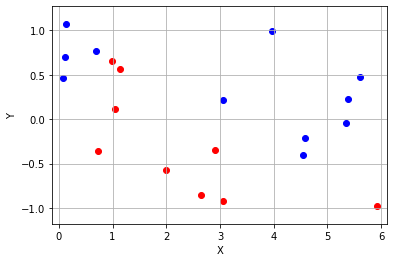

In [8]:
# Problem data:
np.random.seed(11)
import matplotlib.pyplot as plt
n = 20
model = 'sine'
ymargin = 0.
noise = 0.0             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
x1test, x2test, ytest = createDataSet(n*10, model, ymargin, noise)
plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})
Xtrain = np.concatenate((x1, x2), axis = 1)
Xtest = np.concatenate((x1test, x2test), axis = 1)

In [14]:
gb = GBCasero(loss=LogLoss(), reg = False)

ytr = np.ones_like(ytrain)
ytr[ytrain==0] = -1
gb.fit(Xtrain, ytr)

z = gb.predict(ytr)
#print(z)

plotModel(x1,x2,ytrain,gb)

#TODO: medir tiempos, comparar con otro conjunto "real"?

F: [0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535]
Residuos:  [-1.1  0.9 -1.1  0.9 -1.1 -1.1  0.9  0.9 -1.1  0.9  0.9  0.9  0.9  0.9
 -1.1  0.9  0.9 -1.1 -1.1 -1.1]
F: [0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535]
Mult: -8.881784197001252e-16
Residuos:  [-1.1  0.9 -1.1  0.9 -1.1 -1.1  0.9  0.9 -1.1  0.9  0.9  0.9  0.9  0.9
 -1.1  0.9  0.9 -1.1 -1.1 -1.1]
F: [0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535 0.10033535
 0.10033535 0.10033535]
Mult: -2.220446049250313e-15
Residuos:  [-1.1  0.9 -1.1  0.

<ipython-input-2-0cb41415c2f9>:18: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum( residuos/(np.abs(residuos)*(2 - np.abs(residuos))) )
/home/antcc/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**TODO**

- Plot con los clasificadores en cada etapa (mirar en los notebooks de teoría)
- Añadir regularización: shrinkage, subsampling y limit tree depth. Enlazar artículos; ESLR
- Utilizar en conjunto real; hacer CV con M + regularización y encontrar los parámetros óptimos.
- Plot train/test error vs number of iterations on a single dataset.
- Comparar con sklearn
- Median loss?
- Separar en baseGB, classGB y regGB.

## Análisis matemático de la pérdida logarítmica

- ¿Por qué usamos la pérdida log para clasificación (adaptada a $\pm 1$)? (binary cross-entropy, max log-likelihood)
- ¿Por qué usamos sigmoide? Se elige primero sigmoide y luego logloss o al revés?
- Deducción de $F_0$
- Por qué se puede usar $\sigma(F(x))$ para recuperar la probabilidad de $y=1$.